# Fashion MNIST

In [2]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
class EarlyStopping:
    def __init__(self, patience=5, path='model.pt'):
        '''
        Parameters:
        patience (int): maximum number of epochs without improvement of the validation loss
            Default: 5
        path (str): path of the model to be saved to. 
            Default: 'model.pt'
        '''
        self.path = path
        self.patience = patience
        self.counter = 0
        self.min_loss = np.Inf
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.patience is None: return
        if val_loss < self.min_loss: 
            self.save_model(val_loss, model)
            self.min_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            self.early_stop = self.patience < self.counter
      
    def save_model(self, val_loss, model):
        if self.patience is None: return
        torch.save(model.state_dict(), self.path)
        print(f'\t Validation loss decreased: {self.min_loss:>.6f} to {val_loss:>.6f}. Model saved')

    def get_model(self, model):
        if self.patience is None: return model
        model.load_state_dict(torch.load(self.path))
        return model

## Load Dataset

In [4]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

def load_data(batch_size=64, val_size=0.1):
    # Download training data from open datasets
    train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (0.5,))])
    )

    # Download test data from open datasets.
    test_data = datasets.FashionMNIST(
        root="data",
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize((0.5,), (0.5,))])
    )

    # split training set into train and validation set
    num_train = len(train_data)
    num_val = int(val_size*num_train)
    num_train -= num_val
    train_set, val_set = random_split(train_data, [num_train, num_val], generator=torch.Generator().manual_seed(42))

    # load data sets in batches
    train_ldr = DataLoader(train_set, batch_size=batch_size)
    val_ldr = DataLoader(val_set, batch_size=batch_size)
    test_ldr = DataLoader(test_data, batch_size=batch_size)
    
    return train_ldr, val_ldr, test_ldr

## CNN

In [6]:
from torch import nn
from pytorch_model_summary import summary
from hilbert_flatten import HilbertFlatten

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.flatten = HilbertFlatten()
        
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out
    
model = NeuralNetwork()
print(summary(model, torch.zeros((1, 1, 28, 28))))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 32, 28, 28]             320             320
     BatchNorm2d-2     [1, 32, 28, 28]              64              64
            ReLU-3     [1, 32, 28, 28]               0               0
       MaxPool2d-4     [1, 32, 14, 14]               0               0
          Conv2d-5     [1, 64, 12, 12]          18,496          18,496
     BatchNorm2d-6     [1, 64, 12, 12]             128             128
            ReLU-7     [1, 64, 12, 12]               0               0
       MaxPool2d-8       [1, 64, 6, 6]               0               0
          Linear-9            [1, 600]       1,383,000       1,383,000
      Dropout2d-10            [1, 600]               0               0
         Linear-11            [1, 120]          72,120          72,120
         Linear-12             [1, 10]           1,210           1,210
Total

## Network Functions

In [5]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accumulate loss and accuracy
        train_loss += loss.item()*len(y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= size
    correct /= size
    return train_loss, correct

In [6]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()*len(y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    return test_loss, correct

In [16]:
def fit(train_ldr, val_ldr, model, loss_fn, optimizer, patience, n_epochs):
    train_losses = []
    val_losses = []

    # initialize early stoppping
    early_stopping = EarlyStopping(patience=patience)

    for t in range(1, n_epochs+1):
        train_loss, train_acc = train(train_ldr, model, loss_fn, optimizer)
        val_loss, val_acc = test(val_ldr, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        info(t, n_epochs, train_loss, val_loss, train_acc, val_acc)

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print('Terminate by early stopping.')
            break

    model = early_stopping.get_model(model)
    return model, train_losses, val_losses

# prints info about progress
def info(t, n_epochs, train_loss, val_loss, train_acc, val_acc):
    digits = len(str(n_epochs))
    msg = (f'[{t:>{digits}}/{n_epochs:>{digits}}] ' +
         f'train loss: {train_loss:.5f}     ' +
         f'val loss: {val_loss:.5f}      ' +
         f'train acc: {train_acc:.5f}     ' +
         f'val acc: {val_acc:.5f}')
    print(msg)

## Experiments

#### Parameter Setting

In [17]:
# number of epochs
epochs = 1000

# learning rate 
lr = 0.001

# l2 regularization
wd = 0.0

# patience: maximum epochs without improvement of validation loss
patience = 15

# batch size
batch_size = 64

#### Load Data

In [18]:
# load data
train_ldr, val_ldr, test_ldr = load_data(batch_size=batch_size)

# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


#### Fit and Evaluate

[   1/1000] train loss: 0.44544     val loss: 0.32189      train acc: 0.84352     val acc: 0.88450
	 Validation loss decreased: inf to 0.321888. Model saved
[   2/1000] train loss: 0.30276     val loss: 0.30219      train acc: 0.89185     val acc: 0.89250
	 Validation loss decreased: 0.321888 to 0.302191. Model saved
[   3/1000] train loss: 0.26304     val loss: 0.28348      train acc: 0.90563     val acc: 0.89783
	 Validation loss decreased: 0.302191 to 0.283482. Model saved
[   4/1000] train loss: 0.23493     val loss: 0.29218      train acc: 0.91648     val acc: 0.89450
[   5/1000] train loss: 0.21370     val loss: 0.28054      train acc: 0.92313     val acc: 0.90133
	 Validation loss decreased: 0.283482 to 0.280543. Model saved
[   6/1000] train loss: 0.19604     val loss: 0.33776      train acc: 0.92946     val acc: 0.88817
[   7/1000] train loss: 0.18058     val loss: 0.33012      train acc: 0.93491     val acc: 0.89300
[   8/1000] train loss: 0.16557     val loss: 0.34219      t

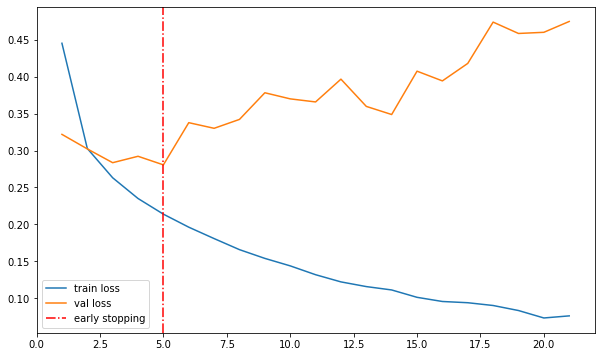

In [19]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

model, train_losses, val_losses = fit(train_ldr, val_ldr, model, loss_fn, optimizer, patience, epochs)
test_loss, accuracy = test(test_ldr, model)
print(f"Test error: \n accuracy: {(100*accuracy):>0.1f}%, avg loss: {test_loss:>8f} \n")


# plot train and test error
fig = plt.figure(figsize=(10, 6))
t = range(1,len(train_losses)+1)
plt.plot(t, train_losses, label='train loss')
plt.plot(t, val_losses, label='val loss')

# early stopping checkpoint
minpos_val = np.argmin(val_losses)+1 
plt.axvline(minpos_val, linestyle='-.', color='r',label='early stopping')

plt.legend()
plt.show()